In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/ML_Project_RL/images'

/content/gdrive/MyDrive/ML_Project_RL/images


In [ ]:
xla_version = '1.8'
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $xla_version

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0   4281      0  0:00:01  0:00:01 --:--:--  4277
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-1.8 ...
Found existing installation: torch 1.10.0+cu111
     |████████████████████████████████| 57 kB 3.1 MB/s 
Uninstalling torch-1.10.0+cu111:
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.293 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
Don

In [ ]:
import gc
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from skimage import io, transform
from skimage.color import gray2rgb
from PIL import Image, ImageEnhance
import cv2
import time
import random
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torch.cuda.amp import GradScaler

In [ ]:
#Preparing the dataset
num_folds = 5
use_fold = 0

image_size = 256

batch_size = 128
batches_per_epoch = 1000
num_epochs = 10
batch_verbose = 100
num_tpu_workers = 8

eta = 0.0001
step = 1
gamma = 0.5

curr_path = os.getcwd()
train_path = os.path.join(curr_path, 'train')
test_path = os.path.join(curr_path, 'test')
class_map = {'happy': 0, 'neutral':1, 'angry': 2, 'fearful': 3, 'surprised': 4, 'disgusted': 5, 'sad': 6}
os.environ['XLA_USE_BF16']                 = '1'
os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '1000000000'

In [ ]:
def prepare_dataset(datapath):
  list_of_classes = os.listdir(datapath)
  labels = []
  image_paths = []
  for idx, img_class in enumerate(list_of_classes):
    path = os.path.join(datapath, img_class)
    images =os.listdir(path)
    for img in images:
      image_paths.append(os.path.join(path, img))
      labels.append(class_map[img_class])
  
  return image_paths, labels

In [ ]:
train_img_paths, train_labels = prepare_dataset(train_path)
test_img_paths, test_labels = prepare_dataset(test_path)

In [ ]:
class_weights = []
total_size = len(train_labels)
_,counts = np.unique(np.array(train_labels), return_counts=True)
for count in counts:
  class_weights.append((count/total_size))

class_weights = torch.Tensor(class_weights)

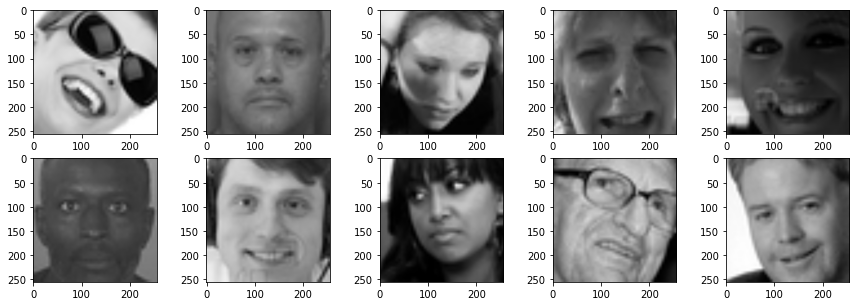

In [ ]:
plt.figure(figsize = (15,5))
for i in range(10):
  index = random.randint(0, len(train_img_paths)-1)
  im = cv2.imread(train_img_paths[index])
  im_resized = cv2.resize(im, (256, 256))
  plt.subplot(2,5,i+1)
  plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))

plt.show()


In [ ]:
class EmotionDataset(Dataset):

    def __init__(self, data_labels, dataset, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = dataset
        self.data_labels = data_labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx]               
        image = Image.open(img_name)
        #image = gray2rgb(image)
        enhancer = ImageEnhance.Sharpness(image)
        image_s = enhancer.enhance(3)
        
        type_p = self.data_labels[idx]
        if self.transform:
            image_s = self.transform(image_s)

        return image_s, type_p

In [ ]:
transform_normal = transforms.Compose([                                      
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    
])
transform_rotate = transforms.Compose([
    transforms.Resize((224,224)),                              
    transforms.RandomRotation(degrees = 20),
    transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])
    
])

transform_flip = transforms.Compose([
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize((224,224)),                              
    transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])
    
])
transform_jitter = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0),
    transforms.Resize((256,256)),                              
    transforms.CenterCrop(240),
    transforms.Resize((224,224)), 
    transforms.ToTensor()
    
])

In [ ]:
train_datasets = []
train_datasets.append(EmotionDataset( train_labels, train_img_paths, transform=transform_normal))
train_datasets.append(EmotionDataset( train_labels, train_img_paths, transform=transform_rotate))
#train_datasets.append(EmotionDataset( train_labels, train_img_paths, transform=transform_flip))
ds = torch.utils.data.ConcatDataset(train_datasets)
total_len = len(ds)
train_len = int(0.8*total_len)
valid_len = total_len - train_len
train_ds, val_ds =  torch.utils.data.random_split(ds, [train_len, valid_len] )
 

In [ ]:
test_datasets = []
test_datasets.append(EmotionDataset( test_labels, test_img_paths, transform=transform_normal))
test_ds = torch.utils.data.ConcatDataset(test_datasets)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return (torch.tensor(torch.sum(preds == labels).item())/len(preds))*100

In [ ]:
#Modified Resnet34 Model
def init_model1():
  model = models.resnet34(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
      if hasattr(module, 'weight'):
        module.weight.requires_grad_(True)
      if hasattr(module, 'bias'):
        module.bias.requires_grad_(True)
  model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=4096, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.5),
                           nn.Linear(in_features=4096, out_features=1024, bias=True),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(in_features=1024, out_features=7, bias=True))
  
  model.name = "ModifiedResnet34_1"
  return model

model = init_model1()
mx= xmp.MpModelWrapper(model)


In [ ]:
from torchsummary import summary
x = torch.randn(1,1,224,224)
summary(model, (1,256,256))
#print(model_x)

In [ ]:
#Modified Resnet50 Model
class ModifiedResnet50(nn.Module):
  def __init__(self,trained):
    super(ModifiedResnet50, self).__init__()
    resnet = models.resnet50(pretrained=trained)
    resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    modules = list(resnet.children())[:-1]
    self.net = nn.Sequential(*modules)
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features = 2048, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(in_features = 4096, out_features = 1024, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(in_features=1024, out_features = 7, bias = True)
    )
        
  def forward(self,x):
    x1  = self.net(x)
    x2 = x1.view(x1.size(0), -1)  
    out = self.classifier(x2)
    return out



In [ ]:
from torchsummary import summary
def init_model3():
  model= ModifiedResnet50(trained=False)
  for param in model.net.parameters():
    param.requires_grad = False
  
  for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
      if hasattr(module, 'weight'):
        module.weight.requires_grad_(True)
      if hasattr(module, 'bias'):
        module.bias.requires_grad_(True)
  model.name = 'ModifiedResnet50'
  return model



In [ ]:
class AverageMeter(object):

  def __init__(self):
    self.reset()
  
  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum/self.count


In [ ]:
def train_fn(epoch, parallel_loader, optimizer, criterion, scheduler, device):
  model.train()
  trn_loss_meter = AverageMeter()

  for batch_idx, (inputs, labels) in enumerate(parallel_loader):
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    

    optimizer.zero_grad()
    preds = model(inputs)
    loss = criterion(preds, labels)
    acc = accuracy(preds,labels)
    loss.backward()
    xm.optimizer_step(optimizer)

    trn_loss_meter.update(loss.detach().item(), inputs.size(0))


    if(batch_idx >0 and (batch_idx % batch_verbose == 0)):
      xm.master_print('--batch {} | cur_loss = {:.6f}, avg_loss = {:.6f}, accuracy = {:.6f}'.format(batch_idx, loss.item(), trn_loss_meter.avg, acc.item()))


    del inputs, labels, preds, loss
    gc.collect()

    if batch_idx > batches_per_epoch:
      break


  del parallel_loader, batch_idx
  gc.collect()

  return trn_loss_meter.avg 



In [ ]:
def valid_fn(epoch, parallel_loader, criterion, device):

  model.eval()
  val_loss_meter = AverageMeter()

  for batch_idx, (inputs, labels ) in enumerate(parallel_loader):

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      preds = model(inputs)
      loss = criterion(preds, labels)
      acc = accuracy(preds, labels)

    val_loss_meter.update(loss.detach().item(), inputs.size(0))

    if (batch_idx >0) and (batch_idx % batch_verbose == 0):
      xm.master_print('-- batch {} | curr_loss = {:.6f}, avg_loss = {:.6f}, acc = {:.6f}'.format(batch_idx, loss.item(), val_loss_meter.avg, acc.item()))
    
    del inputs, labels, preds, loss
    gc.collect()

  del parallel_loader, batch_idx
  gc.collect()

  return val_loss_meter.avg

In [ ]:
def test_fn(model, parallel_loader, criterion, device):

  model.eval()
  test_loss_meter = AverageMeter()
  accuracy_meter = AverageMeter()

  for batch_idx, data in enumerate(parallel_loader):
    inputs = data[0].to(device)
    labels = data[1].to(device)

    with torch.no_grad():
      preds = model(inputs)
      loss = criterion(preds, labels)
      acc = accuracy(preds, labels)



    test_loss_meter.update(loss.detach().item(), inputs.size(0))
    accuracy_meter.update(acc.detach().item(), 1)


    xm.master_print('-- batch {} | curr_loss = {:.6f}, avg_loss = {:.6f}, accuracy_batch = {:.6f} '.format(batch_idx, loss.item(), test_loss_meter.avg, acc.item()))
    
    del inputs, labels, preds, loss, acc
    gc.collect()
  
  del parallel_loader, batch_idx
  gc.collect()

  return test_loss_meter.avg, accuracy_meter.avg


In [ ]:
def _run(model):

  train_sampler = torch.utils.data.distributed.DistributedSampler(train_ds,
                                                                  num_replicas = xm.xrt_world_size(),
                                                                  rank = xm.get_ordinal(),
                                                                  shuffle = True)
  valid_sampler = torch.utils.data.distributed.DistributedSampler(val_ds, num_replicas=xm.xrt_world_size(), rank = xm.get_ordinal(), shuffle=False)


  train_loader = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, sampler = train_sampler,
                                             num_workers = 0, pin_memory = True)
  valid_loader = torch.utils.data.DataLoader(val_ds, batch_size = batch_size, sampler = valid_sampler,
                                             num_workers = 0, pin_memory = True)
  
  device = xm.xla_device()
  model = mx.to(device)
  best_model_wts = copy.deepcopy(model.state_dict())
  scaled_data = eta * xm.xrt_world_size()
  
  criterion = nn.CrossEntropyLoss(class_weights)
  #optimizer = optim.Adam(model.parameters(), lr = scaled_data, weight_decay=1e-5)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.0001)
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, min_lr=0.00001, verbose=True)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)

  trn_losses = []
  val_losses = []
  best_val_loss = 1
 
  gc.collect()
  for epoch in range(num_epochs):
    xm.master_print('-'*55)
    xm.master_print('EPOCH {}/{}'.format(epoch + 1, num_epochs))
    xm.master_print('-'*55)
    xm.master_print('- initialization | TPU cores = {}, lr = {:.6f}'.format(
        xm.xrt_world_size(), optimizer.param_groups[0]['lr']/ xm.xrt_world_size()))
    epoch_start = time.time()
    gc.collect()


    train_loader.sampler.set_epoch(epoch)

    train_start = time.time()
    xm.master_print('- training...')
    para_loader = pl.ParallelLoader(train_loader, [device])
    trn_loss = train_fn(epoch = epoch+1, parallel_loader=para_loader.per_device_loader(device),
                        criterion= criterion,
                        optimizer=optimizer,
                        scheduler = scheduler,
                        device = device)
    del para_loader
    gc.collect()

    valid_start = time.time()
    xm.master_print('-validation...')
    para_loader = pl.ParallelLoader(valid_loader, [device])
    val_loss = valid_fn(epoch = epoch+1,
                        parallel_loader = para_loader.per_device_loader(device),
                        criterion = criterion,
                        device = device)
    
    scheduler.step()
    del para_loader
    gc.collect()

    if val_loss < best_val_loss:
      best_model_wts = copy.deepcopy(model.state_dict())
      best_val_loss = val_loss


    xm.master_print('- elapsed time | train = {:.2f} min, valid = {:.2f} min'.format(
            (valid_start - train_start) / 60, (time.time() - valid_start) / 60))
    xm.master_print('- average loss | train = {:.6f}, valid = {:.6f}'.format(
            trn_loss, val_loss))
    xm.master_print('-'*55)
    xm.master_print('')


    trn_losses.append(trn_loss)
    val_losses.append(val_loss)
    del trn_loss, val_loss
    gc.collect()


  xm.master_print('Best results: loss = {:.6f} (epoch {})'.format(np.min(val_losses), np.argmin(val_losses) + 1))
  xm.save(best_model_wts, 'weights_{}.pt'.format(model.name))
  return trn_losses, val_losses

  

In [ ]:
def _run_test(model):

  test_sampler =  torch.utils.data.distributed.DistributedSampler(test_ds,
                                                                  num_replicas = xm.xrt_world_size(),
                                                                  rank = xm.get_ordinal(),
                                                                  shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_ds, batch_size = 64, sampler = test_sampler,
                                             num_workers = 0)
  
  criterion = nn.CrossEntropyLoss()
  device = xm.xla_device()
  model = mx.to(device)
 
  xm.master_print('Model loaded successfully')

  para_loader = pl.ParallelLoader(test_loader, [device])
  test_loss,accuracy = test_fn(model=model, parallel_loader = para_loader.per_device_loader(device), criterion=criterion ,device=device)

  return accuracy, test_loss


In [ ]:
# wrapper function
def _mp_fn(rank, flags):
    torch.set_default_tensor_type('torch.FloatTensor')
    trn_losses, val_losses = _run(model_ensemble)
    np.save('trn_losses.npy', np.array(trn_losses))
    np.save('val_losses.npy', np.array(val_losses))
    
# modeling
gc.collect()
FLAGS = {}
xmp.spawn(_mp_fn, args = (FLAGS,), nprocs = num_tpu_workers, start_method = 'fork')

In [ ]:
trn_loss = np.load('trn_losses.npy')
val_loss = np.load('val_losses.npy')
epochs = np.arange(1,101)
plt.title("Train and Validation loss with Resnet34")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epochs[1:], trn_loss[1:], label='Train Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
plt.legend()
plt.show

In [ ]:
#Soft Voting Ensemble Model
num_classes = 7
class Ensemble(nn.Module):
   def __init__(self, modelA, modelB, modelC):
     super(Ensemble, self).__init__()
     self.modelA = modelA
     self.modelB = modelB
     self.modelC = modelC


   def forward(self, x):
     output = torch.zeros([x.size(0), num_classes])
     out1 = self.modelA(x.clone())
     out2 = self.modelB(x.clone())
     out3 = self.modelC(x)
     output = (out1 + out2 + out3)
     return output


In [ ]:
modelA = models.vgg16_bn()
modelB = models.resnet34()
modelC = ModifiedResnet50(trained=False)

modelA.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#Modified VGG16 Model
modelA.classifier = nn.Sequential(
    nn.Linear(in_features = 25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(in_features = 4096, out_features = 1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(in_features=1024, out_features = 7, bias = True))
modelA.load_state_dict(torch.load('weights_ModifiedVGG16BN__1.pt'))


modelB.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
modelB.fc = nn.Sequential(nn.Linear(in_features=512, out_features=4096, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.5),
                           nn.Linear(in_features=4096, out_features=1024, bias=True),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(in_features=1024, out_features=7, bias=True))
modelB.load_state_dict(torch.load('weights_ModifiedResnet34_1.pt'))

modelC.load_state_dict(torch.load('weights_ModifiedResnet50.pt'))

model_ensemble = Ensemble(modelA, modelB, modelC)
model_ensemble.name = 'Ensemble_1'
mx= xmp.MpModelWrapper(model_ensemble)


In [ ]:
#Weights of Ensemble Network after Training for 10 epochs
model_ensemble.load_state_dict(torch.load('weights_Ensemble_1.pt'))

<All keys matched successfully>

In [ ]:
x = torch.randn(10,1,256,256)
out = model_ensemble(x)
print(torch.max(out,dim=1))

In [ ]:
 def _mp_fn(rank, flags):
    torch.set_default_tensor_type('torch.FloatTensor')
    final_acc, test_loss = _run_test(model_ensemble)
    xm.master_print('The final accuracy of the ensemble model: ',final_acc)
    
# modeling
gc.collect()
FLAGS = {}
xmp.spawn(_mp_fn, args = (FLAGS,), nprocs = num_tpu_workers, start_method = 'fork')

Calculating the Confusion Matrix for the CNN

In [ ]:
from tqdm import tqdm
def calculate(test_loader, model):
  model.eval()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  n = len(test_loader)
  all_preds = []
  all_labels = []
  tk0 = tqdm(test_loader)
  for _, data in enumerate(tk0):
    input = data[0].to(device)
    labels = data[1].to(device)

    output = model(input)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    all_preds.extend(output) # Save Prediction
    labels = labels.data.cpu().numpy()
    all_labels.extend(labels) # Save Truth

    
    
  return all_labels, all_preds

  



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False): 
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    




In [ ]:
from sklearn.metrics import confusion_matrix
test_loader = DataLoader(test_ds, batch_size=1,shuffle=True) 
targets, preds = calculate(test_loader,model_ensemble)
cm = confusion_matrix(targets,preds)
print(type(cm))

100%|██████████| 7178/7178 [57:44<00:00,  2.07it/s]

<class 'numpy.ndarray'>


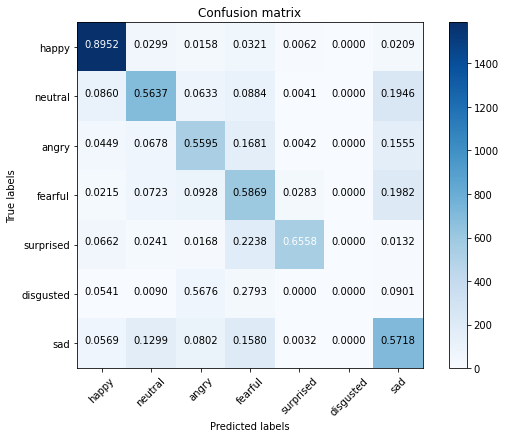

In [ ]:
target_names = ['happy', 'neutral', 'angry', 'fearful', 'surprised', 'disgusted', 'sad']
plot_confusion_matrix(cm, target_names, title='Confusion matrix',normalize=True )

In [ ]:
from sklearn.metrics import f1_score, precision_score, accuracy_score
print('Precision score for Ensemble Model: ', precision_score( targets, preds , average='weighted'))
print('F1 score for Ensemble Model: ', f1_score(targets, preds,  average='weighted'))
print('Accuracy score for Ensemble Model: ', accuracy_score(targets, preds))